In [1]:
from models import *
from utilities import *
from functools import partial
import matplotlib.pyplot as plt

In [2]:
def _gradient(Z, spacing):
    dy, dx = spacing
    return np.gradient(Z, dy, axis=0), np.gradient(Z, dx, axis=1)

def force_balance_ssa(U, V, H, B, n, spacing):
    """
    Compute stresses at bed of glacier.
    """
    dy, dx = spacing
    u_y, u_x = _gradient(U, spacing)
    v_y, v_x = _gradient(V, spacing)
    h_y, h_x = _gradient(H, spacing)
    h = H

    # Compute driving stress components
    rho_ice = 917.0
    rho_water = 1024.0
    g = 9.80665
    s_x = h_x * (1 - rho_ice / rho_water)
    s_y = h_y * (1 - rho_ice / rho_water)
    tdx = -1.0e-3 * rho_ice * g * H * s_x
    tdy = -1.0e-3 * rho_ice * g * H * s_y

    # Compute viscosity
    strain = np.sqrt(u_x**2 + v_y**2 + u_x * v_y + 0.25 * (u_y + v_x)**2) + 1.0e-5
    eta = 0.5 * B * strain**((1.0 - n) / n)

    # Membrane stresses in X-direction
    argx = 2.0 * eta * h * (2.0 * u_x + v_y)
    argy = eta * h * (u_y + v_x)
    tmxx = np.gradient(argx, dx, axis=1)
    tmxy = np.gradient(argy, dy, axis=0)
    tmx = tmxx + tmxy

    # Membrane stresses in Y-direction
    argy = 2.0 * eta * h * (2.0 * v_y + u_x)
    argx = eta * h * (u_y + v_x)
    tmyy = np.gradient(argy, dy, axis=0)
    tmyx = np.gradient(argx, dx, axis=1)
    tmy = tmyy + tmyx

    # Drag
    tbx = tmx + tdx
    tby = tmy + tdy
    driving = np.sqrt(tdx**2 + tdy**2)
    drag = np.sqrt(tbx**2 + tby**2)

    return drag


def print_gp_summary(gp):
    print('Variable values for', gp.name)
    print(' - amplitude:', gp.amplitude.numpy())
    print(' - length scale:', gp.length_scale.numpy())
    print(' - noise variance:', gp.noise_variance.numpy())
    print('')

In [3]:
# Parameters
pars = ParameterClass('run.cfg')

# Load normalizers
norms = make_normalizers()

# Reference x, normalized
with h5py.File(H5FILE, 'r') as fid:
    x_ref = norms['x'](fid['x'][()])
    y_ref = norms['y'](fid['y'][()])

# Make models
mean_net = MeanNetwork(norms)
vgp = create_vgp(x_ref, y_ref, pars.prior.num_inducing_x, pars.prior.num_inducing_y, norms)

# The grids to predict on
factor = 15
arrays = [h5read('data_grids.h5', key) for key in
          ('X', 'Y', 'U', 'V', 'H', 'B_ref', 'mask')]
X, Y, U, V, H, B_ref, mask = [array[::factor, ::factor] for array in arrays]
spacing = (Y[1,0] - Y[0,0], X[0,1] - X[0,0])

# Valid mask (make sure to use even number of points)
mask1d = mask.ravel().nonzero()[0]
nanmask1d = np.invert(mask.ravel())

# Points to predict
X_pts = X.ravel()[mask1d]
Y_pts = Y.ravel()[mask1d]
N_pts = X_pts.size
print('Number of prediction points:', X_pts.size)

# Mask obs grids
for arr in (U, V, H):
    arr.ravel()[nanmask1d] = np.nan

Number of prediction points: 1057


In [4]:
# Create checkpoint manager
CHECKDIR = pars.train.checkdir

print('Restoring from', CHECKDIR)
ckpt_manager = create_checkpoint_manager(
    CHECKDIR,
    mean_net=mean_net,
    vgp=vgp,
    restore=True
)

# Predict
values = mean_net(X_pts.reshape(-1, 1), Y_pts.reshape(-1, 1), inverse_norm=True)
Up, Vp, Hp, B0p = [v.numpy() for v in values]

Restoring from checkpoints/checkpoints_jointA


In [5]:
# First predict whole covariance (if possible)
full_index_points = np.column_stack((X_pts, Y_pts))
full_index_points_normalized = normalize_tensor(
    full_index_points, mean_net.iW_in, mean_net.b_in
)
full_cov = vgp.covariance(index_points=full_index_points_normalized)
print(full_cov.shape)

(1057, 1057)


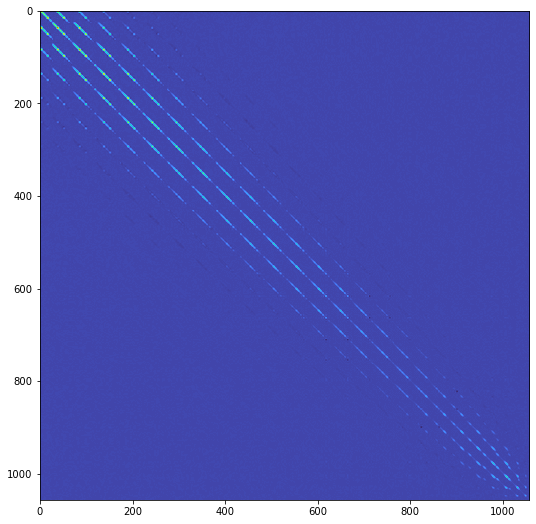

In [6]:
plt.figure(figsize=(12, 9))
plt.imshow(full_cov, cmap='turbo')

## Choosing a block size for Gibbs sampling

For Gibbs sampling, we must choose a nominal block size for the individual (overlapping) covariance blocks. There are two factors to consider when choosing the block size: 1) convergence and sample quality; and 2) computational efficiency. For the former, the larger the block size, the lower the (bad) variance of the generated samples. For the latter, the larger the block size, the _slower_ the sampling speed. However, if the block size is too small, the sampling speed is slow as well. For this problem, it seems like we need a block size of at least 1000.

In [7]:
@tf.function
def _predict_block(xb, yb):
    _index_points = normalize_tensor(
        tf.concat(values=[xb, yb], axis=1),
        mean_net.iW_in, mean_net.b_in
    )
    mean = vgp.mean(index_points=_index_points)
    cov = vgp.covariance(index_points=_index_points)
    return mean, cov

# The grids to predict on
factor = 4
arrays = [h5read('output_rasters.h5', key) for key in
          ('X', 'Y', 'U', 'V', 'H', 'B0')]
X, Y, U, V, H, B0 = [array[::factor, ::factor] for array in arrays]
mask = np.isfinite(U)
spacing = (Y[1,0] - Y[0,0], X[0,1] - X[0,0])

# Valid mask (make sure to use even number of points)
mask1d = mask.ravel().nonzero()[0]
nanmask1d = np.invert(mask.ravel())

# Points to predict
X_pts = X.ravel()[mask1d]
Y_pts = Y.ravel()[mask1d]
N_pts = X_pts.size
print('Number of prediction points:', X_pts.size)

# Build covariance blocks
cov_blocks = []
mean_blocks = []
block_indices = []
block_size = 1000
half_block = block_size // 2
i0 = 0
i1 = i0 + block_size
all_inds = np.arange(N_pts, dtype=int)
while True:

    # Slice indices for block
    bslice = slice(i0, i1)
    xb = X_pts[bslice].reshape(-1, 1)
    yb = Y_pts[bslice].reshape(-1, 1)
    inds = all_inds[bslice]
    
    # Predict sub-covariance
    mean, C = [t.numpy() for t in _predict_block(xb, yb)]
    
    # Break into submatrices of C11, C22, C12
    C11 = C[:half_block, :half_block]
    C12 = C[:half_block, half_block:]
    C22 = C[half_block:, half_block:]
    
    # Compute SVD-reduced arrays
    cov_data = {'C11': C11,
                'C12': C12,
                'C22': C22}
    mu_data = {'mu1': mean[:half_block],
               'mu2': mean[half_block:]}
    
    # Store
    mean_blocks.append(mu_data)
    cov_blocks.append(cov_data)
    block_indices.append((inds[0], inds[-1]+1))
    
    # Update indices
    i0 += half_block
    i1 += half_block
    print(block_indices[-1], i0, i1)

    if (i0 + half_block) > N_pts:
        break
    
n_blocks = len(cov_blocks)
print('Number of blocks:', n_blocks)

Number of prediction points: 14846


2022-07-21 15:54:45.675306: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(0, 1000) 500 1500
(500, 1500) 1000 2000
(1000, 2000) 1500 2500
(1500, 2500) 2000 3000
(2000, 3000) 2500 3500
(2500, 3500) 3000 4000
(3000, 4000) 3500 4500
(3500, 4500) 4000 5000
(4000, 5000) 4500 5500
(4500, 5500) 5000 6000
(5000, 6000) 5500 6500
(5500, 6500) 6000 7000
(6000, 7000) 6500 7500
(6500, 7500) 7000 8000
(7000, 8000) 7500 8500
(7500, 8500) 8000 9000
(8000, 9000) 8500 9500
(8500, 9500) 9000 10000
(9000, 10000) 9500 10500
(9500, 10500) 10000 11000
(10000, 11000) 10500 11500
(10500, 11500) 11000 12000
(11000, 12000) 11500 12500
(11500, 12500) 12000 13000
(12000, 13000) 12500 13500
(12500, 13500) 13000 14000
(13000, 14000) 13500 14500
(13500, 14500) 14000 15000
(14000, 14846) 14500 15500
Number of blocks: 29


In [8]:
# Gibbs sampling
n_samples = 100
rng = np.random.default_rng(142)
samples = np.zeros((n_samples, N_pts))
diag_ind = list(range(half_block))
for i in tqdm(range(n_samples)):
    
    # Generate Gibbs chain
    for b in range(n_blocks):
        
        # Get block data
        mu_data = mean_blocks[b]
        cov_data = cov_blocks[b]
        i0, i1 = block_indices[b]
        mu1 = mu_data['mu1']
        mu2 = mu_data['mu2']
        C11 = cov_data['C11']
        C12 = cov_data['C12']
        C22 = cov_data['C22']
        C21 = C12.transpose()
        iC11 = np.linalg.inv(C11)
        
        # For the first block, use first half of block to generate
        # a sample using mean and covaraiance
        if b == 0:
            z1 = rng.multivariate_normal(mu1, C11, size=1).squeeze()
            samples[i, i0:i0+half_block] = z1
            
        # Compute Schur complement
        # https://en.wikipedia.org/wiki/Schur_complement#Applications_to_probability_theory_and_statistics
        # https://myweb.uiowa.edu/pbreheny/7110/f20/notes/9-02.pdf#page28
        C_schur = C22 - np.dot(C21, np.dot(iC11, C12))
        ns = C_schur.shape[0]
        C_schur[range(ns), range(ns)] += 1.0e-6 
        mu_schur = mu2 + np.dot(C21, np.dot(iC11, z1 - mu1))
        
        # Sample
        z2 = rng.multivariate_normal(mu_schur, C_schur, size=1).squeeze()
        samples[i, i0+half_block:i1] = z2

        # Update block for next one
        mu1 = mu2
        z1 = z2
        C11 = C22

  0%|                                                                        | 0/100 [00:00<?, ?it/s]/var/folders/bj/dgngml3n2gz58d9lf0qzqxh80000gn/T/ipykernel_17791/3324211396.py:26: RuntimeWarning: covariance is not positive-semidefinite.
  z1 = rng.multivariate_normal(mu1, C11, size=1).squeeze()
/var/folders/bj/dgngml3n2gz58d9lf0qzqxh80000gn/T/ipykernel_17791/3324211396.py:38: RuntimeWarning: covariance is not positive-semidefinite.
  z2 = rng.multivariate_normal(mu_schur, C_schur, size=1).squeeze()
100%|██████████████████████████████████████████████████████████████| 100/100 [13:41<00:00,  8.22s/it]


2022.5281602002215 -2285.71428571429
(100, 200)


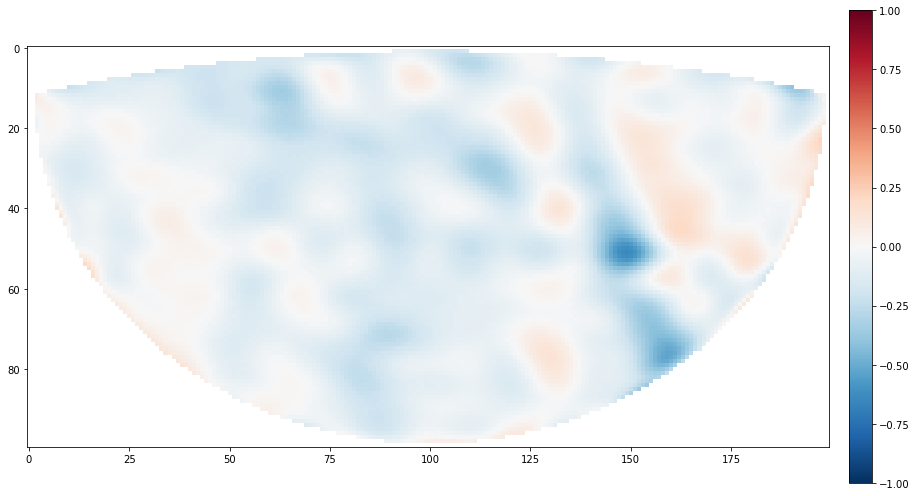

In [9]:
print(X[0, 1] - X[0, 0], Y[1, 0] - Y[0, 0])
with h5py.File('samples.h5', 'w') as fid:
    fid['theta_samples'] = samples
    fid['X'] = X
    fid['Y'] = Y
    fid['U'] = U
    fid['V'] = V
    fid['H'] = H
    fid['B0'] = B0
    fid['x'] = X_pts
    fid['y'] = Y_pts
    fid['mask'] = mask1d

def _make2d(arr):
    out = np.full(X.shape, np.nan, dtype=np.float32)
    out.ravel()[mask1d] = arr.ravel()
    print(out.shape)
    return out

fig, ax = plt.subplots(figsize=(14, 7))
im = ax.imshow(_make2d(samples[30]), cmap='RdBu_r', clim=(-1, 1))
plt.colorbar(im, ax=ax, pad=0.02)
plt.tight_layout()

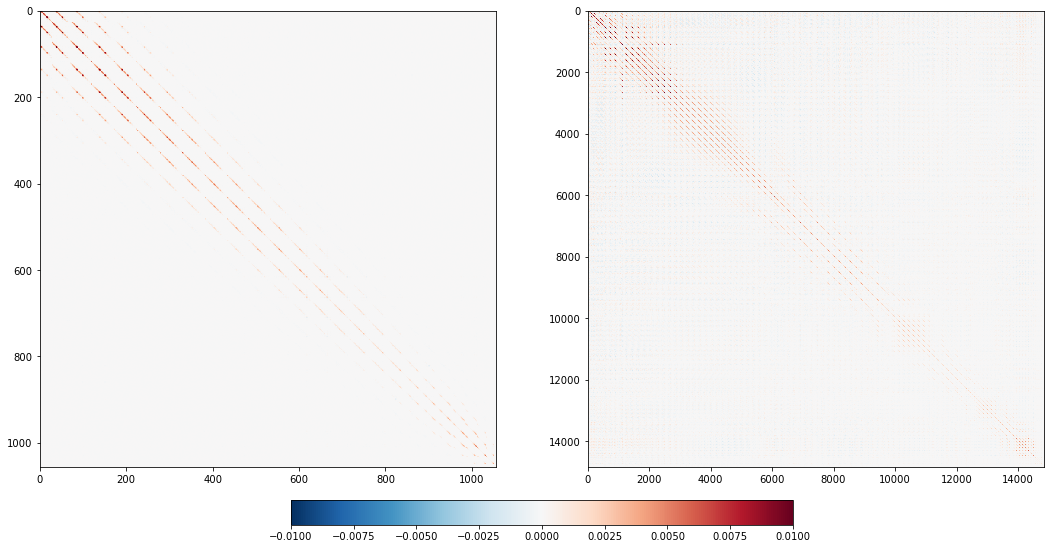

In [15]:
cov = np.cov(samples, rowvar=False)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 12))
im1 = ax1.imshow(full_cov, cmap='RdBu_r', clim=(-0.01, 0.01), interpolation='nearest')
im2 = ax2.imshow(cov, cmap='RdBu_r', clim=(-0.01, 0.01), interpolation='nearest')
plt.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', shrink=0.5, pad=0.05)
#plt.tight_layout()